<a href="https://colab.research.google.com/github/alfredqbit/NU-DDS-8536/blob/main/sepulvedaADDS_8536_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5: Appraise Advanced Clustering Techniques
**Student:** A. Sepúlveda-Jiménez, PhD  
**Course:** DDS-8536 Current Topics in Data Science  
**Dataset:** Statlog (German Credit Data), UCI ML Repository (n=1,000)

This notebook implements:
- Exploratory Data Analysis (EDA)
- DBSCAN (tuned)
- Agglomerative Hierarchical Clustering (single/complete/average linkage + dendrograms)
- Non-classical alternatives: Genetic Algorithm (GA)-optimized k-means and Quantum-behaved PSO (QPSO)-optimized k-means
- Comparison using internal validation metrics (silhouette, Davies–Bouldin, Calinski–Harabasz) and runtime.


In [29]:

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# SciPy for dendrograms
from scipy.cluster.hierarchy import linkage, dendrogram

import time


In [30]:

# Dataset: Statlog (German Credit Data) from UCI.
# UCI link: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data
# DOI: 10.24432/C5NC77

url = "https://archive.ics.uci.edu/static/public/144/statlog+german+credit+data.zip"
# UCI provides a .data file inside the zip; we'll load via pandas from the raw file URL instead:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

columns = [
    "checking_status", "duration_months", "credit_history", "purpose", "credit_amount",
    "savings_status", "employment", "installment_rate", "personal_status_sex", "other_debtors",
    "residence_since", "property", "age_years", "other_installment_plans", "housing",
    "num_existing_credits", "job", "num_dependents", "own_telephone", "foreign_worker",
    "credit_risk"
]

df = pd.read_csv(data_url, sep=" ", header=None, names=columns)
df.head()


,checking_status,duration_months,credit_history,purpose,credit_amount,savings_status,employment,installment_rate,personal_status_sex,other_debtors,...,property,age_years,other_installment_plans,housing,num_existing_credits,job,num_dependents,own_telephone,foreign_worker,credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [31]:

# Separate features and (descriptive) label
X = df.drop(columns=["credit_risk"])
y = df["credit_risk"].copy()  # not used for training; used for descriptive checks

numeric_cols = [
    "duration_months", "credit_amount", "installment_rate", "residence_since",
    "age_years", "num_existing_credits", "num_dependents"
]
cat_cols = [c for c in X.columns if c not in numeric_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop"
)

# Apply preprocessing
X_pre = preprocess.fit_transform(X)
print("Preprocessed feature matrix shape:", X_pre.shape)


Preprocessed feature matrix shape: (1000, 61)


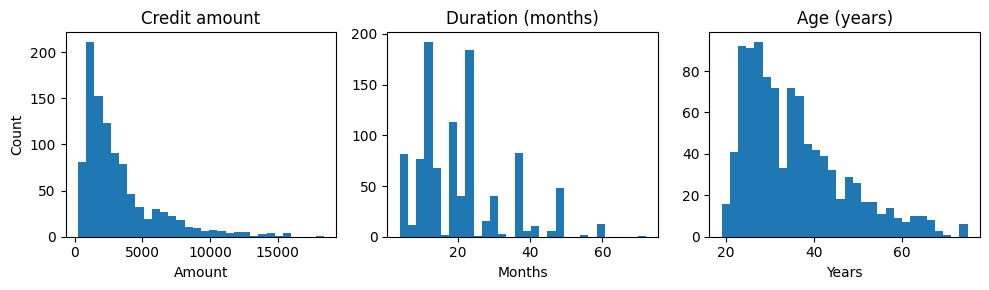

In [32]:

# --- EDA: Numerical distributions ---
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].hist(df["credit_amount"], bins=30)
axes[0].set_title("Credit amount")
axes[0].set_xlabel("Amount")
axes[0].set_ylabel("Count")

axes[1].hist(df["duration_months"], bins=30)
axes[1].set_title("Duration (months)")
axes[1].set_xlabel("Months")

axes[2].hist(df["age_years"], bins=30)
axes[2].set_title("Age (years)")
axes[2].set_xlabel("Years")

fig.tight_layout()
plt.show()


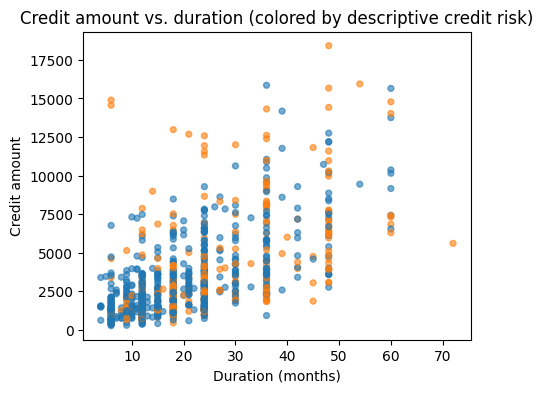

In [33]:

# --- EDA: Credit amount vs duration, colored by descriptive risk label ---
colors = np.where(y.values == 1, "C0", "C1")
plt.figure(figsize=(5,4))
plt.scatter(df["duration_months"], df["credit_amount"], c=colors, alpha=0.6, s=18)
plt.xlabel("Duration (months)")
plt.ylabel("Credit amount")
plt.title("Credit amount vs. duration (colored by descriptive credit risk)")
plt.show()


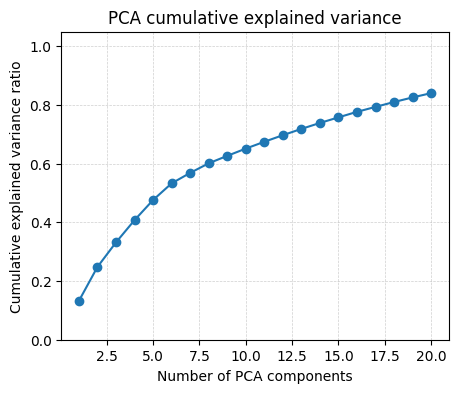

In [34]:

# PCA for clustering representation
pca10 = PCA(n_components=10, random_state=42)
X_pca10 = pca10.fit_transform(X_pre)

# PCA for 2D visualization only
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_pre)

# Cumulative explained variance (first 20 components)
pca20 = PCA(n_components=20, random_state=42).fit(X_pre)
cumvar = np.cumsum(pca20.explained_variance_ratio_)

plt.figure(figsize=(5,4))
plt.plot(range(1, 21), cumvar, marker="o")
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance ratio")
plt.title("PCA cumulative explained variance")
plt.ylim(0, 1.05)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.show()


In [35]:

def evaluate_labels(X_space, labels):
    """Compute internal validation metrics on a feature matrix.
    If labels include -1 (noise), metrics are computed on non-noise points only.
    """
    labels = np.asarray(labels)
    mask = labels != -1
    labels_eval = labels[mask]
    X_eval = X_space[mask]

    unique = np.unique(labels_eval)
    if len(unique) < 2:
        return {
            "n_clusters": len(unique),
            "noise_frac": float(np.mean(labels == -1)),
            "silhouette": np.nan,
            "davies_bouldin": np.nan,
            "calinski_harabasz": np.nan,
        }

    sil = silhouette_score(X_eval, labels_eval)
    dbi = davies_bouldin_score(X_eval, labels_eval)
    chi = calinski_harabasz_score(X_eval, labels_eval)
    return {
        "n_clusters": len(unique),
        "noise_frac": float(np.mean(labels == -1)),
        "silhouette": float(sil),
        "davies_bouldin": float(dbi),
        "calinski_harabasz": float(chi),
    }


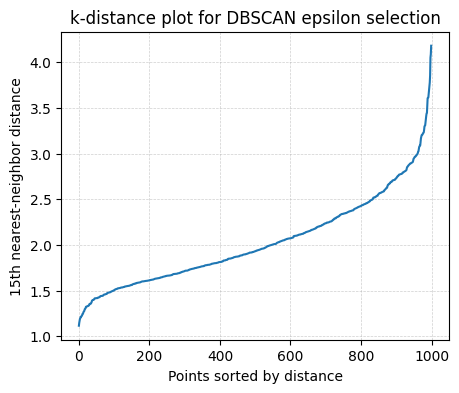

,eps,min_samples,n_clusters,noise_frac,silhouette,davies_bouldin,calinski_harabasz
24,2.0,5,2,0.083,0.213394,1.752843,124.477447
30,2.2,15,2,0.115,0.210784,1.688222,106.540981
29,2.2,10,2,0.081,0.210717,1.734278,117.864426
32,2.4,5,2,0.018,0.210485,1.859979,135.984120
34,2.4,15,2,0.057,0.209074,1.773940,123.008846
33,2.4,10,2,0.037,0.207877,1.810778,128.539005
28,2.2,5,2,0.037,0.207750,1.818674,129.429015
37,2.6,10,2,0.016,0.207587,1.858339,134.159183
36,2.6,5,2,0.010,0.206574,1.873491,133.600965
38,2.6,15,2,0.023,0.206014,1.840771,130.530661


In [36]:

# --- DBSCAN tuning: k-distance plot ---
min_samples = 15
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X_pca10)
distances, _ = neighbors.kneighbors(X_pca10)
kdist = np.sort(distances[:, -1])

plt.figure(figsize=(5,4))
plt.plot(kdist)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples}th nearest-neighbor distance")
plt.title("k-distance plot for DBSCAN epsilon selection")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.show()

# --- Grid search over eps and min_samples (kept small for reproducibility) ---
eps_grid = np.arange(0.8, 3.01, 0.2)
min_samples_grid = [5, 10, 15, 20]

results = []
for eps in eps_grid:
    for ms in min_samples_grid:
        model = DBSCAN(eps=float(eps), min_samples=int(ms), metric="euclidean")
        labels = model.fit_predict(X_pca10)
        metrics = evaluate_labels(X_pca10, labels)
        results.append({"eps": eps, "min_samples": ms, **metrics})

dbscan_df = pd.DataFrame(results)
# A simple validity rule: at least 2 clusters and noise fraction <= 0.30
valid = (dbscan_df["n_clusters"] >= 2) & (dbscan_df["noise_frac"] <= 0.30) & (~dbscan_df["silhouette"].isna())
dbscan_valid = dbscan_df[valid].sort_values("silhouette", ascending=False)

dbscan_valid.head(10)


Best DBSCAN: {'eps': 1.9999999999999998, 'min_samples': 5}
eps                    2.000000
min_samples            5.000000
n_clusters             2.000000
noise_frac             0.083000
silhouette             0.213394
davies_bouldin         1.752843
calinski_harabasz    124.477447
Name: 24, dtype: float64


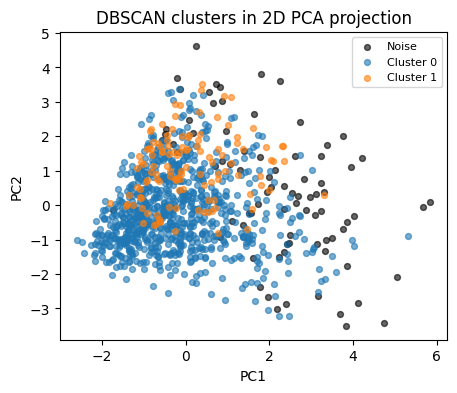

{'n_clusters': 2,
 'noise_frac': 0.083,
 'silhouette': 0.21339445803144785,
 'davies_bouldin': 1.7528432940962824,
 'calinski_harabasz': 124.47744676783638}

In [37]:

# Choose the best configuration by silhouette among valid candidates
best_row = dbscan_valid.iloc[0]
best_eps = float(best_row["eps"])
best_ms = int(best_row["min_samples"])
print("Best DBSCAN:", {"eps": best_eps, "min_samples": best_ms})
print(best_row)

best_dbscan = DBSCAN(eps=best_eps, min_samples=best_ms, metric="euclidean")
labels_db = best_dbscan.fit_predict(X_pca10)

# Visualization in PCA2 space
plt.figure(figsize=(5,4))
for lab in np.unique(labels_db):
    mask = labels_db == lab
    if lab == -1:
        plt.scatter(X_pca2[mask,0], X_pca2[mask,1], c="k", s=18, alpha=0.6, label="Noise")
    else:
        plt.scatter(X_pca2[mask,0], X_pca2[mask,1], s=18, alpha=0.6, label=f"Cluster {lab}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("DBSCAN clusters in 2D PCA projection")
plt.legend(fontsize=8)
plt.show()

evaluate_labels(X_pca10, labels_db)


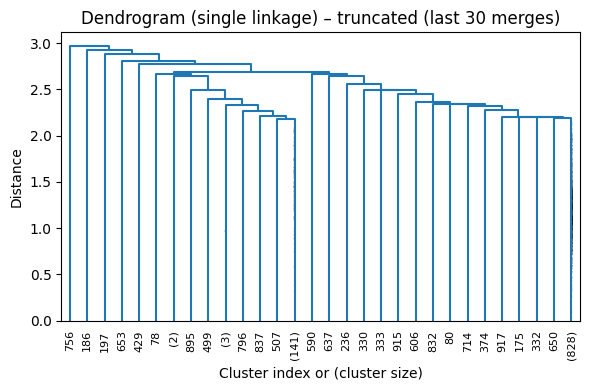

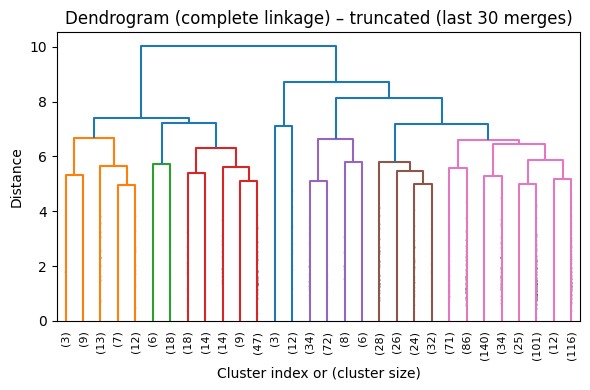

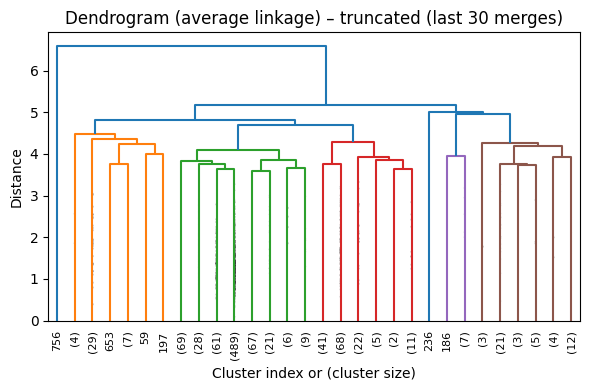

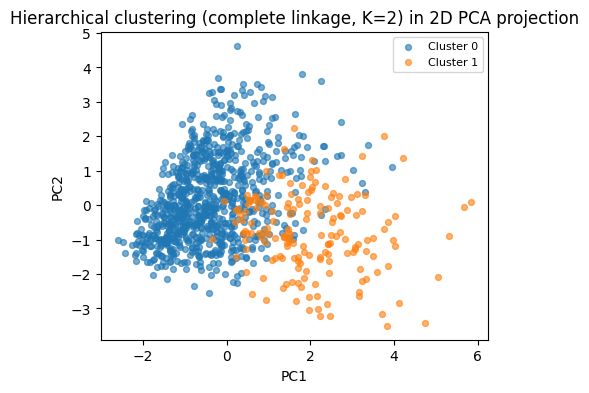

{'n_clusters': 2,
 'noise_frac': 0.0,
 'silhouette': 0.17670107387083786,
 'davies_bouldin': 2.1090293163807265,
 'calinski_harabasz': 124.3237741435792}

In [38]:

# --- Hierarchical clustering: dendrograms (truncated) ---
for method in ["single", "complete", "average"]:
    Z = linkage(X_pca10, method=method, metric="euclidean")
    plt.figure(figsize=(6,4))
    dendrogram(Z, truncate_mode="lastp", p=30, leaf_rotation=90, leaf_font_size=8, show_contracted=True)
    plt.title(f"Dendrogram ({method} linkage) – truncated (last 30 merges)")
    plt.xlabel("Cluster index or (cluster size)")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()

# Flat clustering from complete linkage
hac = AgglomerativeClustering(n_clusters=2, linkage="complete", metric="euclidean")
labels_hac = hac.fit_predict(X_pca10)

plt.figure(figsize=(5,4))
for lab in np.unique(labels_hac):
    mask = labels_hac == lab
    plt.scatter(X_pca2[mask,0], X_pca2[mask,1], s=18, alpha=0.6, label=f"Cluster {lab}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Hierarchical clustering (complete linkage, K=2) in 2D PCA projection")
plt.legend(fontsize=8)
plt.show()

evaluate_labels(X_pca10, labels_hac)


GA best seed: 0 SSE: 7778.575774041192


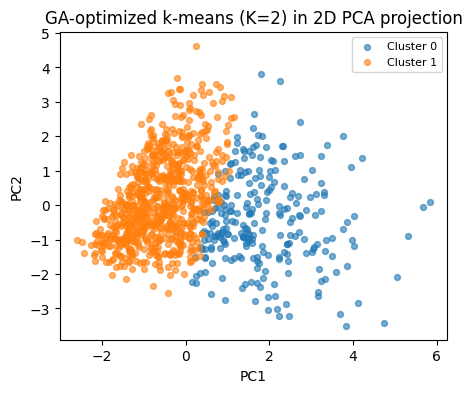

{'n_clusters': 2,
 'noise_frac': 0.0,
 'silhouette': 0.17976149935629732,
 'davies_bouldin': 2.1878252345381686,
 'calinski_harabasz': 157.6034446644573}

In [39]:

# --- Non-classical method 1: Genetic Algorithm (GA) for optimizing k-means centroids ---

def assign_labels_sse(X, centroids):
    # squared Euclidean distances
    d2 = ((X[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2)
    labels = d2.argmin(axis=1)
    sse = d2[np.arange(X.shape[0]), labels].sum()
    return labels, float(sse)

def lloyd_refine(X, centroids, max_iter=100, tol=1e-4):
    prev = np.inf
    centroids = centroids.copy()
    for _ in range(max_iter):
        labels, sse = assign_labels_sse(X, centroids)
        new_centroids = np.vstack([X[labels == k].mean(axis=0) if np.any(labels == k) else centroids[k]
                                  for k in range(centroids.shape[0])])
        shift = np.linalg.norm(new_centroids - centroids)
        centroids = new_centroids
        if abs(prev - sse) < tol or shift < tol:
            break
        prev = sse
    return labels, centroids, sse

def tournament_select(fitness, k=3, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    idx = rng.integers(0, len(fitness), size=k)
    best = idx[np.argmin(fitness[idx])]  # lower SSE is better
    return best

def ga_kmeans_optimize(X, K, pop_size=40, generations=60, crossover_rate=0.8, mutation_rate=0.4,
                      mutation_scale=0.12, random_state=0):
    rng = np.random.default_rng(random_state)
    n, d = X.shape

    # Initialize population from random data points
    population = np.array([X[rng.choice(n, size=K, replace=False)] for _ in range(pop_size)])

    # Fitness
    fitness = np.empty(pop_size)
    for i in range(pop_size):
        _, _, sse = lloyd_refine(X, population[i], max_iter=50)
        fitness[i] = sse

    best_idx = int(np.argmin(fitness))
    best_centroids = population[best_idx].copy()
    best_sse = float(fitness[best_idx])

    for _ in range(generations):
        new_pop = []
        while len(new_pop) < pop_size:
            p1 = population[tournament_select(fitness, k=3, rng=rng)]
            p2 = population[tournament_select(fitness, k=3, rng=rng)]
            child1, child2 = p1.copy(), p2.copy()

            # Crossover (uniform by centroid)
            if rng.random() < crossover_rate:
                mask = rng.random(K) < 0.5
                child1[mask] = p2[mask]
                child2[mask] = p1[mask]

            # Mutation (Gaussian)
            for child in (child1, child2):
                if rng.random() < mutation_rate:
                    child += rng.normal(0, mutation_scale, size=child.shape)

            new_pop.extend([child1, child2])

        population = np.array(new_pop[:pop_size])

        # Evaluate
        for i in range(pop_size):
            _, _, sse = lloyd_refine(X, population[i], max_iter=50)
            fitness[i] = sse

        idx = int(np.argmin(fitness))
        if fitness[idx] < best_sse:
            best_sse = float(fitness[idx])
            best_centroids = population[idx].copy()

    labels, centroids, sse = lloyd_refine(X, best_centroids, max_iter=100)
    return labels, centroids, float(sse)

# Run GA with multiple restarts and keep the best
def ga_best_of_r_runs(X, K, runs=6):
    best = None
    best_sse = np.inf
    best_rs = None
    for rs in range(runs):
        labels, centroids, sse = ga_kmeans_optimize(X, K, random_state=rs)
        if sse < best_sse:
            best_sse = sse
            best = (labels, centroids)
            best_rs = rs
    return best[0], best[1], best_sse, best_rs

labels_ga, centroids_ga, sse_ga, seed_ga = ga_best_of_r_runs(X_pca10, K=2, runs=6)
print("GA best seed:", seed_ga, "SSE:", sse_ga)

plt.figure(figsize=(5,4))
for lab in np.unique(labels_ga):
    m = labels_ga == lab
    plt.scatter(X_pca2[m,0], X_pca2[m,1], s=18, alpha=0.6, label=f"Cluster {lab}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("GA-optimized k-means (K=2) in 2D PCA projection")
plt.legend(fontsize=8)
plt.show()

evaluate_labels(X_pca10, labels_ga)


QPSO SSE: 7778.575774041192


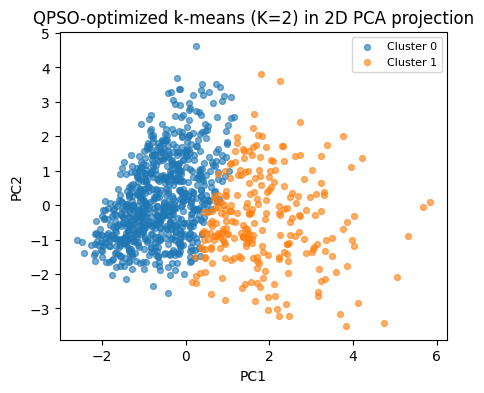

{'n_clusters': 2,
 'noise_frac': 0.0,
 'silhouette': 0.17976149935629732,
 'davies_bouldin': 2.1878252345381686,
 'calinski_harabasz': 157.6034446644573}

In [40]:

# --- Non-classical method 2: Quantum-behaved Particle Swarm Optimization (QPSO) for k-means centroids ---

def qpso_kmeans_optimize(X, K, n_particles=30, iters=60, beta_start=1.0, beta_end=0.4, random_state=1):
    rng = np.random.default_rng(random_state)
    n, d = X.shape

    # Initialize particles from random data points
    particles = np.array([X[rng.choice(n, size=K, replace=False)] for _ in range(n_particles)])

    def refine_sse(centroids):
        _, _, sse = lloyd_refine(X, centroids, max_iter=50)
        return float(sse)

    pbest = particles.copy()
    pbest_fit = np.array([refine_sse(pbest[i]) for i in range(n_particles)])
    gbest_idx = int(np.argmin(pbest_fit))
    gbest = pbest[gbest_idx].copy()
    gbest_fit = float(pbest_fit[gbest_idx])

    for t in range(iters):
        beta = beta_start - (beta_start - beta_end) * (t / max(1, iters - 1))
        mbest = pbest.mean(axis=0)

        for i in range(n_particles):
            u = rng.random(size=(K, d))
            phi = rng.random(size=(K, d))
            p = phi * pbest[i] + (1 - phi) * gbest
            sign = np.where(rng.random(size=(K, d)) < 0.5, -1.0, 1.0)
            new_pos = p + sign * beta * np.abs(mbest - particles[i]) * np.log(1.0 / u)
            particles[i] = new_pos

        # Update bests
        for i in range(n_particles):
            fit = refine_sse(particles[i])
            if fit < pbest_fit[i]:
                pbest_fit[i] = fit
                pbest[i] = particles[i].copy()

        idx = int(np.argmin(pbest_fit))
        if pbest_fit[idx] < gbest_fit:
            gbest_fit = float(pbest_fit[idx])
            gbest = pbest[idx].copy()

    labels, centroids, sse = lloyd_refine(X, gbest, max_iter=100)
    return labels, centroids, float(sse)

labels_qpso, centroids_qpso, sse_qpso = qpso_kmeans_optimize(X_pca10, K=2)
print("QPSO SSE:", sse_qpso)

plt.figure(figsize=(5,4))
for lab in np.unique(labels_qpso):
    m = labels_qpso == lab
    plt.scatter(X_pca2[m,0], X_pca2[m,1], s=18, alpha=0.6, label=f"Cluster {lab}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("QPSO-optimized k-means (K=2) in 2D PCA projection")
plt.legend(fontsize=8)
plt.show()

evaluate_labels(X_pca10, labels_qpso)


In [41]:

# --- Comparison across methods ---
start = time.time()
_ = best_dbscan.fit_predict(X_pca10)
t_db = time.time() - start

start = time.time()
_ = hac.fit_predict(X_pca10)
t_hac = time.time() - start

start = time.time()
_ = ga_kmeans_optimize(X_pca10, K=2, random_state=seed_ga)
t_ga = time.time() - start

start = time.time()
_ = qpso_kmeans_optimize(X_pca10, K=2, random_state=1)
t_qpso = time.time() - start

metrics_db = evaluate_labels(X_pca10, labels_db)
metrics_hac = evaluate_labels(X_pca10, labels_hac)
metrics_ga = evaluate_labels(X_pca10, labels_ga)
metrics_qpso = evaluate_labels(X_pca10, labels_qpso)

comparison = pd.DataFrame([
    {"Method":"DBSCAN", **metrics_db, "runtime_sec":t_db},
    {"Method":"Hierarchical (complete)", **metrics_hac, "runtime_sec":t_hac},
    {"Method":"GA-KMeans", **metrics_ga, "runtime_sec":t_ga},
    {"Method":"QPSO-KMeans", **metrics_qpso, "runtime_sec":t_qpso},
])

comparison


,Method,n_clusters,noise_frac,silhouette,davies_bouldin,calinski_harabasz,runtime_sec
0,DBSCAN,2,0.083,0.213394,1.752843,124.477447,0.019711
1,Hierarchical (complete),2,0.000,0.176701,2.109029,124.323774,0.011333
2,GA-KMeans,2,0.000,0.179761,2.187825,157.603445,4.088266
3,QPSO-KMeans,2,0.000,0.179761,2.187825,157.603445,3.583185


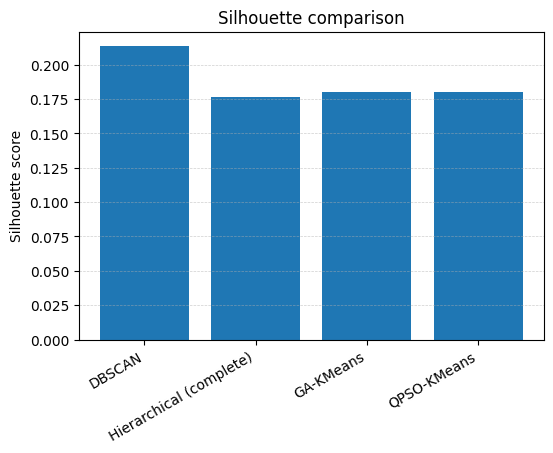

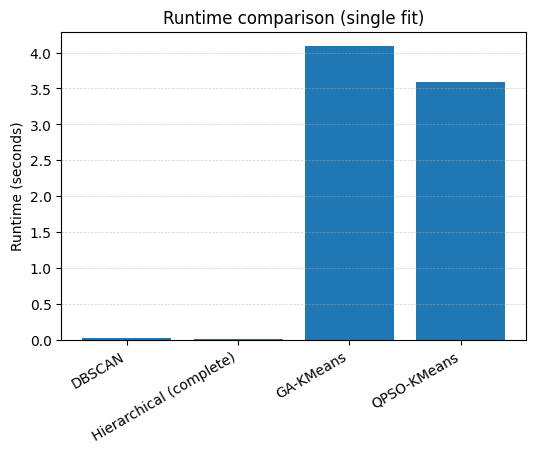

In [42]:

# Visualize silhouette and runtime
plt.figure(figsize=(6,4))
plt.bar(comparison["Method"], comparison["silhouette"])
plt.ylabel("Silhouette score")
plt.title("Silhouette comparison")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y", linestyle="--", linewidth=0.5, alpha=0.6)
plt.show()

plt.figure(figsize=(6,4))
plt.bar(comparison["Method"], comparison["runtime_sec"])
plt.ylabel("Runtime (seconds)")
plt.title("Runtime comparison (single fit)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y", linestyle="--", linewidth=0.5, alpha=0.6)
plt.show()
